In [1]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Omar-Adel-2025
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:04<00:00, 34.4MB/s]


# ***Import Libraries***

In [2]:
import tensorflow as tf
import keras,os,cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ***Reading Data***

In [3]:
TRAINING_PATH = '/content/brain-tumor-mri-dataset/Training'
TESTING_PATH = '/content/brain-tumor-mri-dataset/Testing'
SIZE = 224
NUM_CLASSES = 4
RESCALE=1./255
ROTATION_RANGE=20

SHEAR_RANGE=0.2
ZOOM_RANGE=0.05

HORIZONTAL_FLIP=True

BATCH_SIZE=32

In [4]:
#listdir => Lists files or folders within the specified path.
for i in os.listdir(TRAINING_PATH):
    print(i, len(os.listdir(os.path.join(TRAINING_PATH, i))))

meningioma 1339
pituitary 1457
glioma 1321
notumor 1595


In [5]:
for i in os.listdir(TESTING_PATH):
    print(i, len(os.listdir(os.path.join(TESTING_PATH, i))))

meningioma 306
pituitary 300
glioma 300
notumor 405


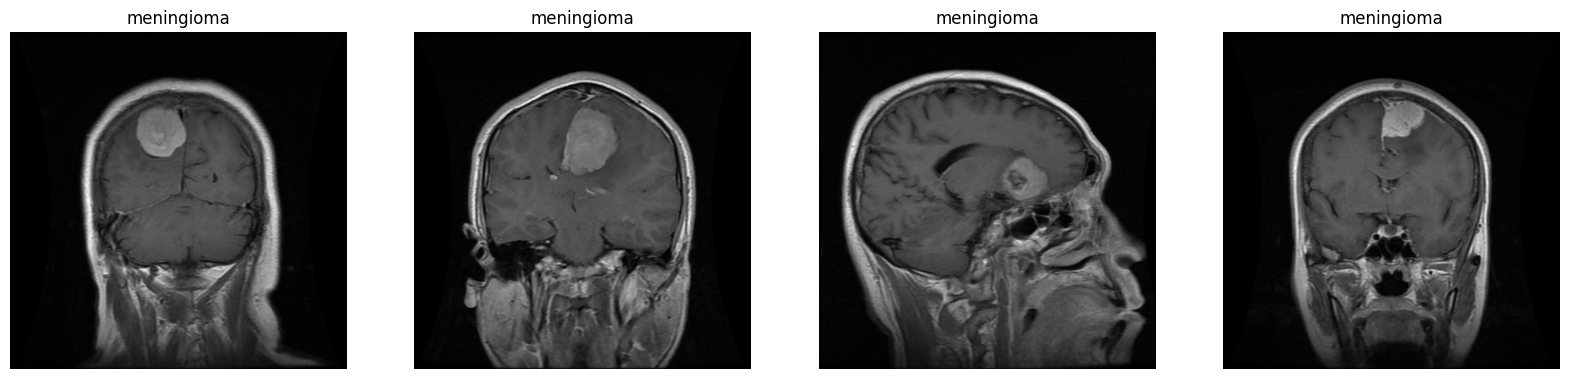

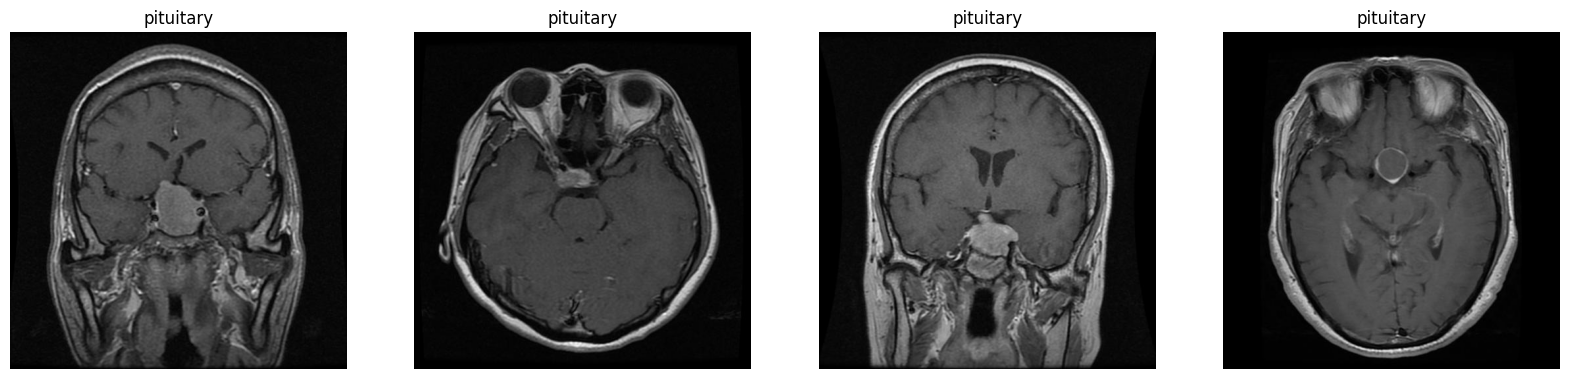

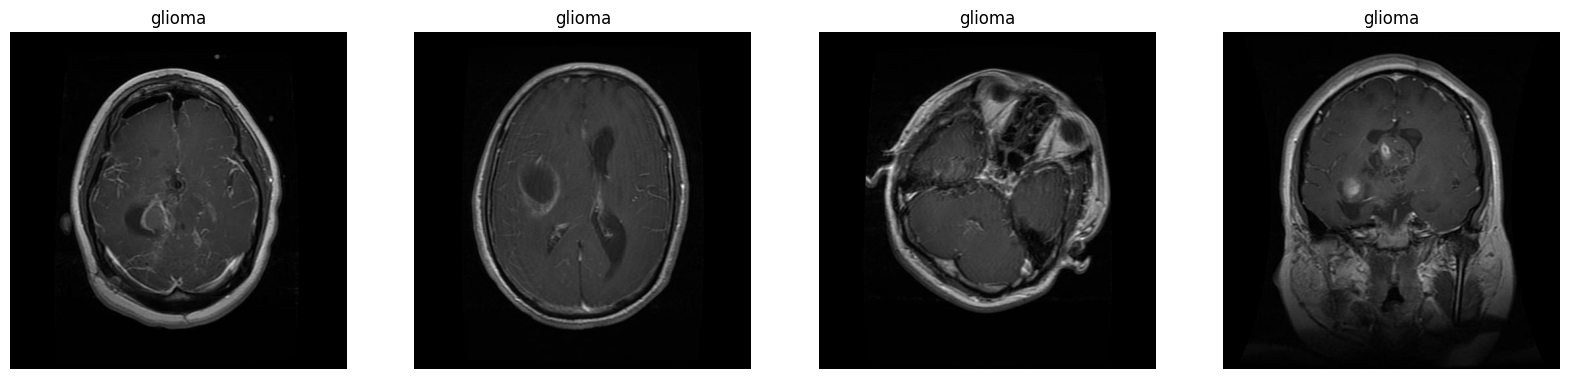

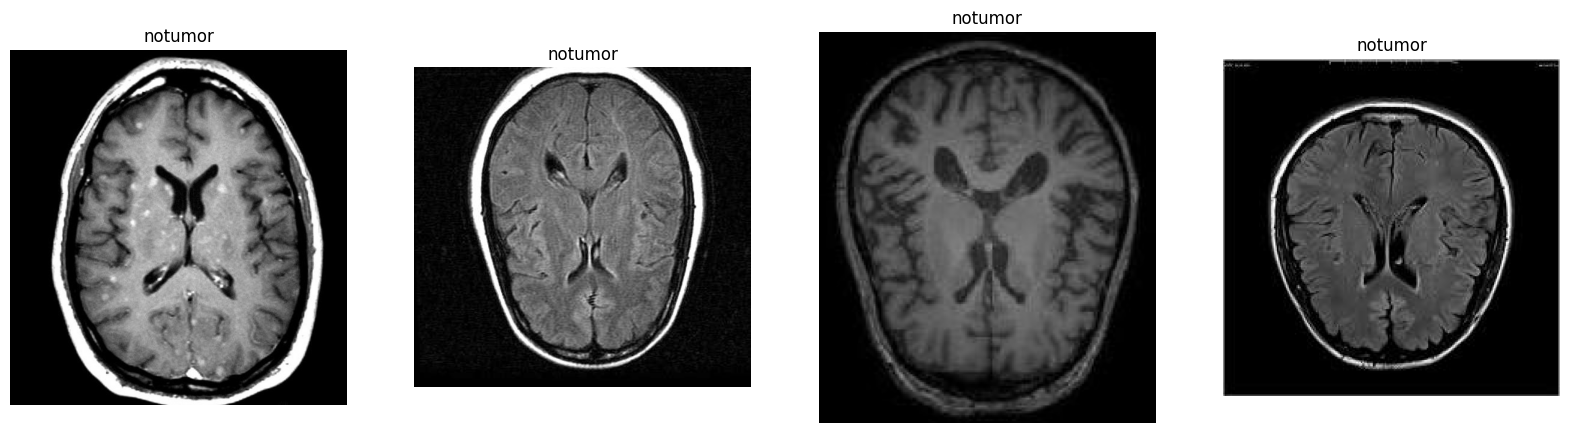

In [6]:
for label in os.listdir(TRAINING_PATH):
    plt.figure(figsize=(20,20))
    count=0
    for i,j in enumerate(os.listdir(os.path.join(TRAINING_PATH, label))):
        plt.subplot(1,4,i+1)
        img = cv2.imread(os.path.join(TRAINING_PATH, label, j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        count+=1
        if count==4:
            break
plt.show()


# ***Show size of images***

In [7]:
images_size=[]
for label in os.listdir(TRAINING_PATH):
    folder_path=os.path.join(TRAINING_PATH,label)
    for image_name in tqdm(os.listdir(folder_path)):
        img_path=os.path.join(folder_path,image_name)
        img=cv2.imread(img_path)
        shape=img.shape
        images_size.append(shape)

100%|██████████| 1595/1595 [00:01<00:00, 1079.01it/s]


In [8]:
print(list(set(images_size))[:10])

[(395, 367, 3), (290, 236, 3), (717, 717, 3), (302, 216, 3), (245, 206, 3), (512, 434, 3), (250, 201, 3), (274, 230, 3), (442, 442, 3), (228, 233, 3)]


here is a difference in the sizes of the images, so must resize the images for CNN to enter

# ***Preprocessing***

In [9]:
def read_resize_data(PATH):
    LABELS=os.listdir(PATH)
    X=[]
    y=[]

    for label in LABELS:

        folder_path=os.path.join(PATH,label)
        for image_name in tqdm(os.listdir(folder_path)):
            img_path=os.path.join(folder_path,image_name)
            img=cv2.imread(img_path)
            img = cv2.resize(img, (SIZE, SIZE))
            X.append(img)
            y.append(LABELS.index(label))

    return X,y

In [10]:
X_train,y_train=read_resize_data(TRAINING_PATH)
X_test,y_test=read_resize_data(TESTING_PATH)

100%|██████████| 405/405 [00:00<00:00, 1227.26it/s]


**Shuffling data helps avoid model bias, enhances generalization, and ensures fair distribution of examples across training iterations, making the training process more robust.**

In [11]:
X_train,y_train=shuffle(X_train,y_train,random_state=0)
X_test,y_test=shuffle(X_test,y_test,random_state=0)

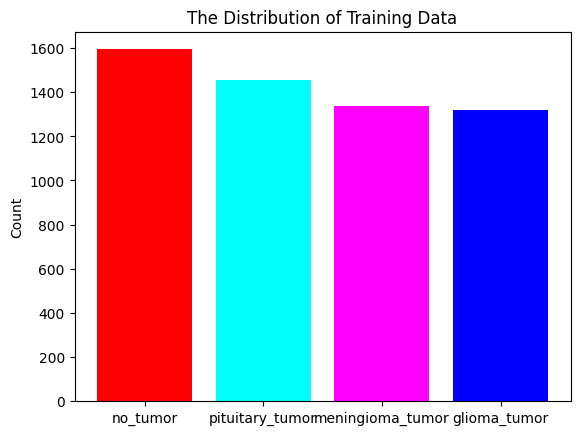

In [12]:
plt.bar(['no_tumor','pituitary_tumor','meningioma_tumor','glioma_tumor'],
        pd.Series(y_train).value_counts(),color=['red','cyan','magenta','blue'])

plt.title('The Distribution of Training Data')
plt.ylabel('Count')
plt.show()

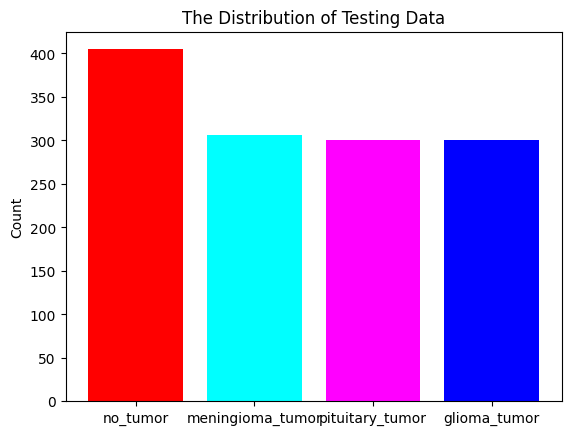

In [13]:
plt.bar(['no_tumor','meningioma_tumor','pituitary_tumor','glioma_tumor']
         ,pd.Series(y_test).value_counts(),color=['red','cyan','magenta','blue'])
plt.title('The Distribution of Testing Data')
plt.ylabel('Count')
plt.show()

In [14]:
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [15]:
print(len(X_train))
print(len(X_test))
print(len(X_val))
print(len(y_train))
print(len(y_test))
print(len(y_val))

5712
655
656
5712
655
656


In [16]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [17]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=NUM_CLASSES)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=NUM_CLASSES)
y_val=tf.keras.utils.to_categorical(y_val,num_classes=NUM_CLASSES)

In [18]:
print('The shape of X_train',X_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of X_val',X_val.shape)
print('The shape of y_train',y_train.shape)
print('The shape of y_test',y_test.shape)
print('The shape of y_val',y_val.shape)

The shape of X_train (5712, 224, 224, 3)
The shape of X_test (655, 224, 224, 3)
The shape of X_val (656, 224, 224, 3)
The shape of y_train (5712, 4)
The shape of y_test (655, 4)
The shape of y_val (656, 4)


# ***Data Augmentation***

In [19]:
train_datagen = ImageDataGenerator(rescale=RESCALE,rotation_range=ROTATION_RANGE,
            shear_range=SHEAR_RANGE,zoom_range=ZOOM_RANGE,horizontal_flip=HORIZONTAL_FLIP)

val_datagen=ImageDataGenerator(rescale=RESCALE)

test_datagen = ImageDataGenerator(rescale=RESCALE)

In [20]:
train_gen=train_datagen.flow(X_train,y_train,batch_size=BATCH_SIZE)
val_gen=val_datagen.flow(X_val,y_val,batch_size=BATCH_SIZE)
test_gen=test_datagen.flow(X_test,y_test,batch_size=BATCH_SIZE)

# ***Build Model***

In [31]:
n_classes = 4
# building a linear stack of layers with the sequential model
model = Sequential([
                    #layer1
                    Conv2D(filters =64,kernel_size=4,activation='relu',input_shape=(224, 224, 3)),
                    MaxPooling2D(pool_size=2),

                    #layer2
                    Conv2D(filters =32,kernel_size=4,activation='relu'),
                    MaxPooling2D(pool_size=2),
                    Dropout(0.2),

                    #layer3
                    Conv2D(filters =16,kernel_size=4,activation='relu'),
                    MaxPooling2D(pool_size=2),

                    Dropout(0.1),
                    Flatten(),
                    Dense(units=128,activation='relu'),
                    Dense(units=128,activation='relu'),
                    Dense(units=4,activation='softmax')
])

In [32]:
model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
history = model.fit ( x = train_gen , validation_data = val_gen , epochs = 10 )

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - accuracy: 0.5247 - loss: 1.0400 - val_accuracy: 0.7576 - val_loss: 0.5829
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 396ms/step - accuracy: 0.8007 - loss: 0.4912 - val_accuracy: 0.7866 - val_loss: 0.4995
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 391ms/step - accuracy: 0.8531 - loss: 0.3852 - val_accuracy: 0.8277 - val_loss: 0.4283
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 380ms/step - accuracy: 0.8626 - loss: 0.3406 - val_accuracy: 0.8872 - val_loss: 0.3057
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 375ms/step - accuracy: 0.8965 - loss: 0.2743 - val_accuracy: 0.8887 - val_loss: 0.2793
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.9130 - loss: 0.2259 - val_accuracy: 0.8902 - val_loss: 0.2608
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 374ms/step - accuracy: 0.9276 - loss: 0.1988 - val_accuracy: 0.8841 - val_loss: 0.2809
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 374ms/step - accuracy: 0.9197 - loss: 0